In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
import tensorflow_probability as tfp  # Import TensorFlow Probability

def gaussian_kernel(size: int, mean: float, std: float):
    """Creates a Gaussian kernel for convolution."""
    d = tfp.distributions.Normal(mean, std)  # Use tfp.distributions instead of tf.distributions
    vals = d.prob(tf.range(start=-size, limit=size+1, dtype=tf.float32))
    gauss_kernel = tf.einsum('i,j->ij',
                             vals,
                             vals)
    return gauss_kernel / tf.reduce_sum(gauss_kernel)

def apply_gaussian_blur(image):
    """Applies Gaussian blur to an image."""
    kernel_size = 5
    sigma = 1.0
    channels = image.shape[-1]
    kernel = gaussian_kernel(kernel_size, 0.0, sigma)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]
    kernel = tf.tile(kernel, [1, 1, channels, 1])
    return tf.nn.depthwise_conv2d(image[tf.newaxis, ...],
                                  kernel,
                                  strides=[1, 1, 1, 1],
                                  padding='SAME')[0]

ModuleNotFoundError: No module named 'tensorflow_probability'

In [13]:

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Adding a channel dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # Rotate images up to 10 degrees
    width_shift_range=0.1,  # Shift images horizontally
    height_shift_range=0.1,  # Shift images vertically
    zoom_range=0.1,  # Zoom images by 10%
    preprocessing_function=apply_gaussian_blur  # Apply Gaussian blur to each image
)

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.GaussianNoise(0.1, input_shape=(28, 28, 1)),  # Add Gaussian noise layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit the model using the data generator
history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                    epochs=10, 
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // 16)


AttributeError: module 'tensorflow' has no attribute 'distributions'

Epoch 1/10
3750/3750 [==============================] - 21s 5ms/step - loss: 0.1137 - accuracy: 0.9652 - val_loss: 0.0467 - val_accuracy: 0.9841
Epoch 2/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0357 - val_accuracy: 0.9891
Epoch 3/10
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0398 - val_accuracy: 0.9874
Epoch 4/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0304 - val_accuracy: 0.9897
Epoch 5/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.0393 - val_accuracy: 0.9880
Epoch 6/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.0367 - val_accuracy: 0.9887
Epoch 7/10
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0099 - accuracy: 0.9965 - val_loss: 0.0376 - val_ac

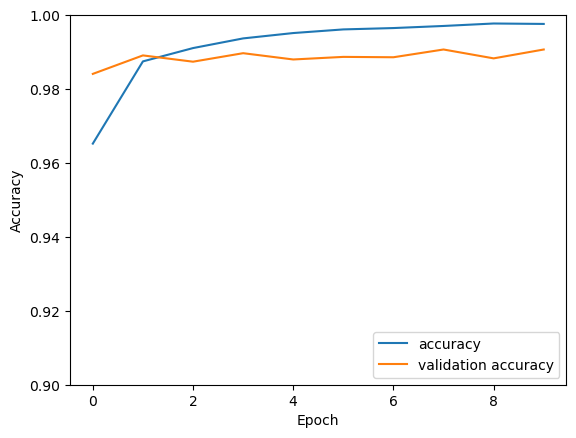

In [ ]:

# noise_factor = 0.5
# x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
# x_train_noisy = tf.clip_by_value(x_train_noisy, 0., 1.)

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
# ])

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

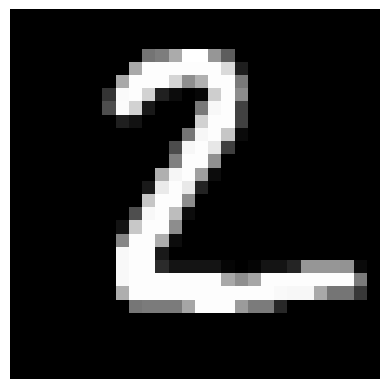

1/1 [==============================] - 0s 30ms/step
2


In [ ]:
import numpy as np
random_image = x_test[1]
fig, axarr = plt.subplots(1, 1)
axarr.imshow(random_image.reshape(28, 28), cmap="gray")
axarr.axis('off')
plt.show()

prediction = model.predict(tf.expand_dims(random_image, 0))
predicted_class = np.argmax(prediction)
print(predicted_class)
